In [17]:
import argparse
import inspect
import logging
import math
import os

import torch
import torch.nn.functional as F
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration
from tqdm.auto import tqdm

from diffusers import DDPMScheduler, DDIMScheduler
from diffusers.optimization import get_scheduler
from diffusers.training_utils import EMAModel
from accelerate import DistributedDataParallelKwargs

from time import time
import numpy as np
import shutil
from diffusion.util import instantiate_from_config, load_config, time_management
from ai4ha.diffusion.pipelines.pipeline_ddpm_1d import DDPMPipeline
from diffusion.pipelines.pipeline_ddim import DDIMPipeline
from ai4ha.diffusion.models.unet_1d import UNet1DModel
import matplotlib.pyplot as plt

In [29]:
SCHEDULERS = {
    'DDPM': DDPMScheduler,
    'DDIM': DDIMScheduler
}

PIPELINES = {
    'DDPM': DDPMPipeline,
    'DDIM': DDIMPipeline
}

DIRS = ['checkpoints', 'logs', 'samples', "final", "model"]


# Will error if the minimal version of diffusers is not installed. Remove at your own risks.
# check_min_version("0.14.0.dev0")

logger = get_logger(__name__, log_level="INFO")


def _extract_into_tensor(arr, timesteps, broadcast_shape):
    """
    Extract values from a 1-D numpy array for a batch of indices.

    :param arr: the 1-D numpy array.
    :param timesteps: a tensor of indices into the array to extract.
    :param broadcast_shape: a larger shape of K dimensions with the batch
                            dimension equal to the length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
    """
    if not isinstance(arr, torch.Tensor):
        arr = torch.from_numpy(arr)
    res = arr[timesteps].float().to(timesteps.device)
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res.expand(broadcast_shape)


def get_diffuser_scheduler(config):
    scheduler = SCHEDULERS[config['diffuser']['type']]

    if 'clip_sample' not in config['diffuser']:
        clip = True
    else:
        clip = config['diffuser']['clip_sample']
    params = {    
        'num_train_timesteps':config['diffuser']['num_steps'],
        'beta_schedule':config['diffuser']['beta_schedule'],
        'clip_sample': clip
    }

    if "prediction_type" in set(inspect.signature(scheduler.__init__).parameters.keys()):
        params['prediction_type'] = config['diffuser']['prediction_type']
    if ("variance_type" in set(inspect.signature(scheduler.__init__).parameters.keys())) and ("variance_type" in config['diffuser']):
        params['variance_type'] = config['diffuser']['variance_type']
    if "betas" in config['diffuser']:
        params['beta_start'] = config['diffuser']['betas'][0]
        params['beta_end'] = config['diffuser']['betas'][1]

    return scheduler(**params)

In [30]:
config = load_config("configs/MITBIH-DDPM-s192-l128-124-r3-t1000-linear-lr5-local")

In [31]:
BASE_DIR = f"{config['exp_dir']}/logs/{config['name']}"

for dir in DIRS:
    os.makedirs(f"{BASE_DIR}/{dir}", exist_ok=True)

accparams = config['accelerator']
# accparams["logging_dir"] = f"{BASE_DIR}/logs"
accparams["project_dir"] = BASE_DIR

if 'projectconf' in config:
    accparams['project_config'] = ProjectConfiguration(
        **config['projectconf'])

ddp_kwargs = DistributedDataParallelKwargs(
    find_unused_parameters=accparams['gradient_accumulation_steps'] > 1)
accelerator = Accelerator(**accparams, kwargs_handlers=[ddp_kwargs])
# Make one log on every process with the configuration for debugging.
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger.info(accelerator.state, main_process_only=False)

model = UNet1DModel(**config['model']['params'])
if 'class_embed_type' in config['model']['params']:
    class_conditoned = config['model']['params'][
        'class_embed_type'] is None
else:
    class_conditoned = False
model.config_name = config['name']

model.disable_gradient_checkpointing()

# Create EMA for the model.
if 'ema' in config:
    ema_model = EMAModel(
        model.parameters(),
        decay=config['ema']['max_decay'],
        use_ema_warmup=True,
        inv_gamma=config['ema']['inv_gamma'],
        power=config['ema']['power'],
        model_cls=UNet1DModel,
        model_config=model.config,
    )

# Initialize the scheduler
noise_scheduler = get_diffuser_scheduler(config)

# Initialize the optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config['train']['learning_rate'] * accelerator.num_processes,
    betas=(config['optimizer']['beta1'], config['optimizer']['beta2']),
    weight_decay=config['optimizer']['weight_decay'],
    eps=config['optimizer']['epsilon'],
)

# Prepare the dataset
train_data = instantiate_from_config(config['dataset']['train'])
test_data = instantiate_from_config(config['dataset']['test'])
train_dataloader = torch.utils.data.DataLoader(
    train_data, **config['dataset']["dataloader"])

logger.info(f"Dataset size: {len(train_data)}")

lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=config['train']['lr_warmup_steps'] *
    accparams['gradient_accumulation_steps'],
    num_training_steps=(len(train_dataloader) * config['train']['epochs']),
)

# Prepare everything with our `accelerator`.
model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, lr_scheduler)

if 'ema' in config:
    ema_model.to(accelerator.device)

total_batch_size = config['dataset']['dataloader']['batch_size'] * \
    accelerator.num_processes * accparams['gradient_accumulation_steps']
num_update_steps_per_epoch = math.ceil(
    len(train_dataloader) / accparams['gradient_accumulation_steps'])
max_train_steps = config['train']['epochs'] * num_update_steps_per_epoch

global_step = 0
first_epoch = 0

# Get the most recent checkpoint
print(f'{BASE_DIR}/checkpoints/')
dirs = os.listdir(f'{BASE_DIR}/checkpoints/')
dirs = [d for d in dirs if d.startswith("checkpoint")]
# print(dirs)
if dirs != []:
    dirs = sorted(dirs, key=lambda x: int(x.split("_")[1]))
    path = dirs[-1] if len(dirs) > 0 else None
else:
    path = None

logger.info(f'CHECKPOINT: {path}')

resume_from_checkpoint = True
if path is None:
    accelerator.print(
        f"Checkpoint does not exist. Starting a new training run.")
    resume_from_checkpoint = None
    resume_step = 0
else:
    accelerator.load_state(os.path.join(f'{BASE_DIR}/checkpoints/', path))
    global_step = int(path.split("_")[1]) * \
        config['train']['checkpoint_freq']
    resume_global_step = global_step * \
        accparams['gradient_accumulation_steps']
    first_epoch = global_step // num_update_steps_per_epoch
    # * accparams['gradient_accumulation_steps']))
    resume_step = (resume_global_step % (num_update_steps_per_epoch))
    accelerator.print(
        f"Resuming from checkpoint {path} - Resume step: {global_step} - Epoch step: {resume_step}"
    )

hps = {
    "num_iterations":
    config['train']['epochs'],
    "learning_rate":
    config['train']['learning_rate'] * accelerator.num_processes
}
accelerator.init_trackers(
    config['name'],
    config=hps,
    init_kwargs={"wandb": {
        "dir": os.path.join(BASE_DIR, "logs")
    }})
logger.info(f"MEM: {torch.cuda.max_memory_allocated()}")

last_time = time()
qe_time = []

if 'time' in config:
    time_budget = config['time'] * 60
else:
    time_budget = 2000


02/02/2024 09:55:55 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no



Class 0 = (72471, 188)
Class 1 = (2223, 188)
Class 2 = (5788, 188)
Class 3 = (641, 188)
Class 4 = (6431, 188)
X_train shape is (87554, 1, 192)
y_train shape is (87554,)
--------------------------------
-------TEST DATA-------


02/02/2024 09:55:57 - INFO - __main__ - Dataset size: 87554
02/02/2024 09:55:57 - INFO - __main__ - CHECKPOINT: None
02/02/2024 09:55:57 - INFO - __main__ - MEM: 528253952


Class 0 = (18118, 188)
Class 1 = (556, 188)
Class 2 = (1448, 188)
Class 3 = (162, 188)
Class 4 = (1608, 188)
X_test shape is (21892, 1, 192)
y_test shape is (21892,)
/home/bejar/PycharmProjects/misiones/Series/Models/Diffusers//logs/MITBIH-DDPM-s192-l128-124-r3-t1000-linear-lr5/checkpoints/
Checkpoint does not exist. Starting a new training run.


In [32]:
model.train();

In [33]:
for step, batch in enumerate(train_dataloader):
    # logger.info(f"*{epoch} - {step}")
    # Skip steps until we reach the resumed step
    if resume_from_checkpoint and epoch == first_epoch and step < resume_step:
        if step % accparams['gradient_accumulation_steps'] == 0:
            progress_bar.update(1)
        continue

    clean_images, labels = batch
    clean_images = clean_images.to(dtype=torch.float32)

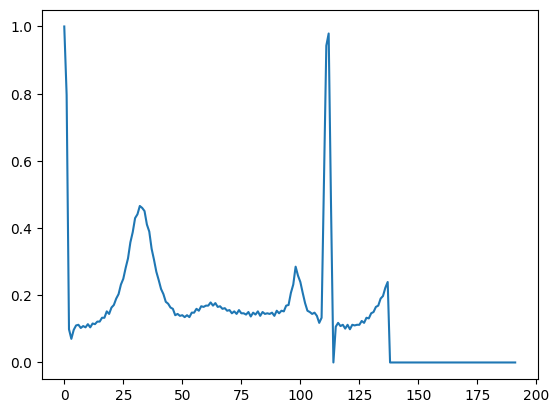

In [40]:
plt.plot(clean_images[0][0].cpu().detach().numpy());

In [35]:
noise = torch.randn(clean_images.shape).to(clean_images.device)
bsz = clean_images.shape[0]
# Sample a random timestep for each image
timesteps = torch.randint(
    0,
    noise_scheduler.config.num_train_timesteps, (bsz, ),
    device=clean_images.device).long()

# Add noise to the clean images according to the noise magnitude at each timestep
# (this is the forward diffusion process)
noisy_images = noise_scheduler.add_noise(clean_images, noise,
                                            timesteps)


In [36]:
timesteps

tensor([552,  97], device='cuda:0')

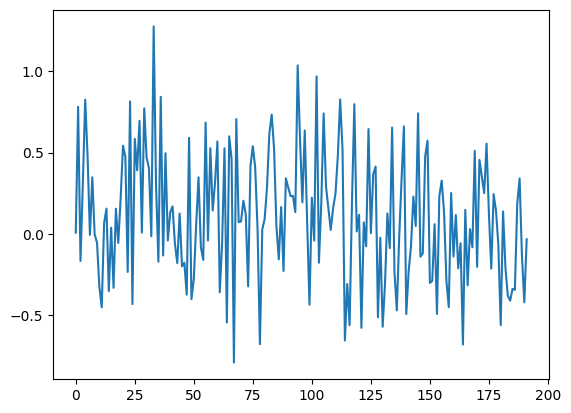

In [39]:
plt.plot(noisy_images[0][0].cpu().detach().numpy());

In [1]:
import numpy as np

In [3]:
a = np.load('/home/bejar/bsc/Data/PTBChap/ptbxl_chapman_combined_train.npz')

In [8]:
a.files

['samples', 'classes']